# PTN Template
This notebook serves as a template for single dataset PTN experiments  
It can be run on its own by setting STANDALONE to True (do a find for "STANDALONE" to see where)  
But it is intended to be executed as part of a *papermill.py script. See any of the   
experimentes with a papermill script to get started with that workflow.  

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Required Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "labels_source",
    "labels_target",
    "domains_source",
    "domains_target",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "n_shot",
    "n_way",
    "n_query",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_transforms_source",
    "x_transforms_target",
    "episode_transforms_source",
    "episode_transforms_target",
    "pickle_name",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "torch_default_dtype"
}

In [3]:


standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337


standalone_parameters["num_examples_per_domain_per_label_source"]=100
standalone_parameters["num_examples_per_domain_per_label_target"]=100

standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 100

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "target_accuracy"

standalone_parameters["x_transforms_source"] = ["unit_power"]
standalone_parameters["x_transforms_target"] = ["unit_power"]
standalone_parameters["episode_transforms_source"] = []
standalone_parameters["episode_transforms_target"] = []

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

# uncomment for CORES dataset
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)


standalone_parameters["labels_source"] = ALL_NODES
standalone_parameters["labels_target"] = ALL_NODES

standalone_parameters["domains_source"] = [1]
standalone_parameters["domains_target"] = [2,3,4,5]

standalone_parameters["pickle_name"] = "cores.stratified_ds.2022A.pkl"


# Uncomment these for ORACLE dataset
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )
# standalone_parameters["labels_source"] = ALL_SERIAL_NUMBERS
# standalone_parameters["labels_target"] = ALL_SERIAL_NUMBERS
# standalone_parameters["domains_source"] = [8,20, 38,50]
# standalone_parameters["domains_target"] = [14, 26, 32, 44, 56]
# standalone_parameters["pickle_name"] = "oracle.frame_indexed.stratified_ds.2022A.pkl"
# standalone_parameters["num_examples_per_domain_per_label_source"]=1000
# standalone_parameters["num_examples_per_domain_per_label_target"]=1000

# Uncomment these for Metahan dataset
# standalone_parameters["labels_source"] = list(range(19))
# standalone_parameters["labels_target"] = list(range(19))
# standalone_parameters["domains_source"] = [0]
# standalone_parameters["domains_target"] = [1]
# standalone_parameters["pickle_name"] = "metehan.stratified_ds.2022A.pkl"
# standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])
# standalone_parameters["num_examples_per_domain_per_label_source"]=200
# standalone_parameters["num_examples_per_domain_per_label_target"]=100


standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])

In [4]:
# Parameters
parameters = {
    "experiment_name": "tuned_1v2:wisig",
    "device": "cuda",
    "lr": 0.0001,
    "labels_source": [
        "1-10",
        "1-12",
        "1-14",
        "1-16",
        "1-18",
        "1-19",
        "1-8",
        "10-11",
        "10-17",
        "10-4",
        "10-7",
        "11-1",
        "11-10",
        "11-19",
        "11-20",
        "11-4",
        "11-7",
        "12-19",
        "12-20",
        "12-7",
        "13-14",
        "13-18",
        "13-19",
        "13-20",
        "13-3",
        "13-7",
        "14-10",
        "14-11",
        "14-12",
        "14-13",
        "14-14",
        "14-19",
        "14-20",
        "14-7",
        "14-8",
        "14-9",
        "15-1",
        "15-19",
        "15-6",
        "16-1",
        "16-16",
        "16-19",
        "16-20",
        "17-10",
        "17-11",
        "18-1",
        "18-10",
        "18-11",
        "18-12",
        "18-13",
        "18-14",
        "18-15",
        "18-16",
        "18-17",
        "18-19",
        "18-2",
        "18-20",
        "18-4",
        "18-5",
        "18-7",
        "18-8",
        "18-9",
        "19-1",
        "19-10",
        "19-11",
        "19-12",
        "19-13",
        "19-14",
        "19-15",
        "19-19",
        "19-2",
        "19-20",
        "19-3",
        "19-4",
        "19-6",
        "19-7",
        "19-8",
        "19-9",
        "2-1",
        "2-13",
        "2-15",
        "2-3",
        "2-4",
        "2-5",
        "2-6",
        "2-7",
        "2-8",
        "20-1",
        "20-12",
        "20-14",
        "20-15",
        "20-16",
        "20-18",
        "20-19",
        "20-20",
        "20-3",
        "20-4",
        "20-5",
        "20-7",
        "20-8",
        "3-1",
        "3-13",
        "3-18",
        "3-2",
        "3-8",
        "4-1",
        "4-10",
        "4-11",
        "5-1",
        "5-5",
        "6-1",
        "6-15",
        "6-6",
        "7-10",
        "7-11",
        "7-12",
        "7-13",
        "7-14",
        "7-7",
        "7-8",
        "7-9",
        "8-1",
        "8-13",
        "8-14",
        "8-18",
        "8-20",
        "8-3",
        "8-8",
        "9-1",
        "9-7",
    ],
    "labels_target": [
        "1-10",
        "1-12",
        "1-14",
        "1-16",
        "1-18",
        "1-19",
        "1-8",
        "10-11",
        "10-17",
        "10-4",
        "10-7",
        "11-1",
        "11-10",
        "11-19",
        "11-20",
        "11-4",
        "11-7",
        "12-19",
        "12-20",
        "12-7",
        "13-14",
        "13-18",
        "13-19",
        "13-20",
        "13-3",
        "13-7",
        "14-10",
        "14-11",
        "14-12",
        "14-13",
        "14-14",
        "14-19",
        "14-20",
        "14-7",
        "14-8",
        "14-9",
        "15-1",
        "15-19",
        "15-6",
        "16-1",
        "16-16",
        "16-19",
        "16-20",
        "17-10",
        "17-11",
        "18-1",
        "18-10",
        "18-11",
        "18-12",
        "18-13",
        "18-14",
        "18-15",
        "18-16",
        "18-17",
        "18-19",
        "18-2",
        "18-20",
        "18-4",
        "18-5",
        "18-7",
        "18-8",
        "18-9",
        "19-1",
        "19-10",
        "19-11",
        "19-12",
        "19-13",
        "19-14",
        "19-15",
        "19-19",
        "19-2",
        "19-20",
        "19-3",
        "19-4",
        "19-6",
        "19-7",
        "19-8",
        "19-9",
        "2-1",
        "2-13",
        "2-15",
        "2-3",
        "2-4",
        "2-5",
        "2-6",
        "2-7",
        "2-8",
        "20-1",
        "20-12",
        "20-14",
        "20-15",
        "20-16",
        "20-18",
        "20-19",
        "20-20",
        "20-3",
        "20-4",
        "20-5",
        "20-7",
        "20-8",
        "3-1",
        "3-13",
        "3-18",
        "3-2",
        "3-8",
        "4-1",
        "4-10",
        "4-11",
        "5-1",
        "5-5",
        "6-1",
        "6-15",
        "6-6",
        "7-10",
        "7-11",
        "7-12",
        "7-13",
        "7-14",
        "7-7",
        "7-8",
        "7-9",
        "8-1",
        "8-13",
        "8-14",
        "8-18",
        "8-20",
        "8-3",
        "8-8",
        "9-1",
        "9-7",
    ],
    "episode_transforms_source": [],
    "episode_transforms_target": [],
    "domains_source": [3],
    "domains_target": [1, 2, 4],
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "n_shot": 3,
    "n_way": 130,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "pickle_name": "wisig.node3-19.stratified_ds.2022A.pkl",
    "x_transforms_source": ["unit_mag"],
    "x_transforms_target": ["unit_mag"],
    "dataset_seed": 1337,
    "seed": 1337,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
# (This is due to the randomized initial weights)
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
###################################
# Build the dataset
###################################

if p.x_transforms_source == []: x_transform_source = None
else: x_transform_source = get_chained_transform(p.x_transforms_source) 

if p.x_transforms_target == []: x_transform_target = None
else: x_transform_target = get_chained_transform(p.x_transforms_target)

if p.episode_transforms_source == []: episode_transform_source = None
else: raise Exception("episode_transform_source not implemented")

if p.episode_transforms_target == []: episode_transform_target = None
else: raise Exception("episode_transform_target not implemented")


eaf_source = Episodic_Accessor_Factory(
    labels=p.labels_source,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_source,
    example_transform_func=episode_transform_source,
    
)
train_original_source, val_original_source, test_original_source = eaf_source.get_train(), eaf_source.get_val(), eaf_source.get_test()


eaf_target = Episodic_Accessor_Factory(
    labels=p.labels_target,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_target,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_target,
    example_transform_func=episode_transform_target,
)
train_original_target, val_original_target, test_original_target = eaf_target.get_train(), eaf_target.get_val(), eaf_target.get_test()


transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
# Some quick unit tests on the data
from steves_utils.transforms import get_average_power, get_average_magnitude

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_source))

assert q_x.dtype == eval(p.torch_default_dtype)
assert s_x.dtype == eval(p.torch_default_dtype)

print("Visually inspect these to see if they line up with expected values given the transforms")
print('x_transforms_source', p.x_transforms_source)
print('x_transforms_target', p.x_transforms_target)
print("Average magnitude, source:", get_average_magnitude(q_x[0].numpy()))
print("Average power, source:", get_average_power(q_x[0].numpy()))

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_target))
print("Average magnitude, target:", get_average_magnitude(q_x[0].numpy()))
print("Average power, target:", get_average_power(q_x[0].numpy()))


Visually inspect these to see if they line up with expected values given the transforms
x_transforms_source ['unit_mag']
x_transforms_target ['unit_mag']
Average magnitude, source: 1.0
Average power, source: 1.2096208


Average magnitude, target: 1.0
Average power, target: 1.3668913


In [12]:
###################################
# Build the model
###################################
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=(2,256))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [13]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 45], examples_per_second: 2015.0563, train_label_loss: 4.6138, 


epoch: 1, [batch: 5 / 45], examples_per_second: 3973.0581, train_label_loss: 4.1563, 


epoch: 1, [batch: 9 / 45], examples_per_second: 4037.5059, train_label_loss: 3.4876, 


epoch: 1, [batch: 14 / 45], examples_per_second: 4059.4999, train_label_loss: 2.8434, 


epoch: 1, [batch: 18 / 45], examples_per_second: 4059.4869, train_label_loss: 2.5183, 


epoch: 1, [batch: 23 / 45], examples_per_second: 3982.0742, train_label_loss: 2.1496, 


epoch: 1, [batch: 27 / 45], examples_per_second: 4054.1098, train_label_loss: 1.8584, 


epoch: 1, [batch: 31 / 45], examples_per_second: 4064.5101, train_label_loss: 1.7960, 


epoch: 1, [batch: 36 / 45], examples_per_second: 4097.1880, train_label_loss: 1.6500, 


epoch: 1, [batch: 40 / 45], examples_per_second: 4151.1670, train_label_loss: 1.5961, 


epoch: 1, source_val_acc_label: 0.7712, target_val_acc_label: 0.7079, source_val_label_loss: 1.4059, target_val_label_loss: 1.6487, 


New best


epoch: 2, [batch: 1 / 45], examples_per_second: 500.1631, train_label_loss: 1.2987, 


epoch: 2, [batch: 5 / 45], examples_per_second: 4020.1451, train_label_loss: 1.1731, 


epoch: 2, [batch: 9 / 45], examples_per_second: 4127.7598, train_label_loss: 1.3254, 


epoch: 2, [batch: 14 / 45], examples_per_second: 4122.4054, train_label_loss: 1.2142, 


epoch: 2, [batch: 18 / 45], examples_per_second: 4124.9899, train_label_loss: 0.9838, 


epoch: 2, [batch: 23 / 45], examples_per_second: 4039.7362, train_label_loss: 1.2520, 


epoch: 2, [batch: 27 / 45], examples_per_second: 4127.1083, train_label_loss: 1.2598, 


epoch: 2, [batch: 31 / 45], examples_per_second: 4123.0014, train_label_loss: 0.8894, 


epoch: 2, [batch: 36 / 45], examples_per_second: 4163.4954, train_label_loss: 0.8586, 


epoch: 2, [batch: 40 / 45], examples_per_second: 4223.6388, train_label_loss: 1.0362, 


epoch: 2, source_val_acc_label: 0.8308, target_val_acc_label: 0.7684, source_val_label_loss: 0.9323, target_val_label_loss: 1.2788, 


New best


epoch: 3, [batch: 1 / 45], examples_per_second: 492.9728, train_label_loss: 1.0507, 


epoch: 3, [batch: 5 / 45], examples_per_second: 4024.1758, train_label_loss: 0.8643, 


epoch: 3, [batch: 9 / 45], examples_per_second: 4138.8466, train_label_loss: 0.7330, 


epoch: 3, [batch: 14 / 45], examples_per_second: 4129.7278, train_label_loss: 0.9635, 


epoch: 3, [batch: 18 / 45], examples_per_second: 4133.9060, train_label_loss: 0.6141, 


epoch: 3, [batch: 23 / 45], examples_per_second: 4046.0865, train_label_loss: 0.6541, 


epoch: 3, [batch: 27 / 45], examples_per_second: 4128.7646, train_label_loss: 0.6392, 


epoch: 3, [batch: 31 / 45], examples_per_second: 4136.4447, train_label_loss: 0.7489, 


epoch: 3, [batch: 36 / 45], examples_per_second: 4161.4071, train_label_loss: 0.7416, 


epoch: 3, [batch: 40 / 45], examples_per_second: 4224.5649, train_label_loss: 0.5613, 


epoch: 3, source_val_acc_label: 0.8744, target_val_acc_label: 0.7936, source_val_label_loss: 0.6600, target_val_label_loss: 1.1115, 


New best


epoch: 4, [batch: 1 / 45], examples_per_second: 493.7835, train_label_loss: 0.7634, 


epoch: 4, [batch: 5 / 45], examples_per_second: 4036.4927, train_label_loss: 0.7020, 


epoch: 4, [batch: 9 / 45], examples_per_second: 4131.3001, train_label_loss: 0.7168, 


epoch: 4, [batch: 14 / 45], examples_per_second: 4128.8009, train_label_loss: 0.7155, 


epoch: 4, [batch: 18 / 45], examples_per_second: 4131.0810, train_label_loss: 0.4968, 


epoch: 4, [batch: 23 / 45], examples_per_second: 4053.1436, train_label_loss: 0.4598, 


epoch: 4, [batch: 27 / 45], examples_per_second: 4125.2786, train_label_loss: 0.5369, 


epoch: 4, [batch: 31 / 45], examples_per_second: 4133.1697, train_label_loss: 0.3426, 


epoch: 4, [batch: 36 / 45], examples_per_second: 4162.1911, train_label_loss: 0.5520, 


epoch: 4, [batch: 40 / 45], examples_per_second: 4211.9862, train_label_loss: 0.3877, 


epoch: 4, source_val_acc_label: 0.9038, target_val_acc_label: 0.8162, source_val_label_loss: 0.4916, target_val_label_loss: 0.9780, 


New best


epoch: 5, [batch: 1 / 45], examples_per_second: 496.1338, train_label_loss: 0.4767, 


epoch: 5, [batch: 5 / 45], examples_per_second: 4007.1147, train_label_loss: 0.5406, 


epoch: 5, [batch: 9 / 45], examples_per_second: 4108.2937, train_label_loss: 0.3067, 


epoch: 5, [batch: 14 / 45], examples_per_second: 4118.7994, train_label_loss: 0.5820, 


epoch: 5, [batch: 18 / 45], examples_per_second: 4118.3023, train_label_loss: 0.5102, 


epoch: 5, [batch: 23 / 45], examples_per_second: 4041.2273, train_label_loss: 0.5668, 


epoch: 5, [batch: 27 / 45], examples_per_second: 4120.5416, train_label_loss: 0.3783, 


epoch: 5, [batch: 31 / 45], examples_per_second: 4112.3372, train_label_loss: 0.4377, 


epoch: 5, [batch: 36 / 45], examples_per_second: 4161.0997, train_label_loss: 0.3585, 


epoch: 5, [batch: 40 / 45], examples_per_second: 4219.3915, train_label_loss: 0.4308, 


epoch: 5, source_val_acc_label: 0.9224, target_val_acc_label: 0.8254, source_val_label_loss: 0.3864, target_val_label_loss: 0.9184, 


New best


epoch: 6, [batch: 1 / 45], examples_per_second: 495.9532, train_label_loss: 0.3007, 


epoch: 6, [batch: 5 / 45], examples_per_second: 4037.5537, train_label_loss: 0.2931, 


epoch: 6, [batch: 9 / 45], examples_per_second: 4131.3345, train_label_loss: 0.2192, 


epoch: 6, [batch: 14 / 45], examples_per_second: 4133.9133, train_label_loss: 0.2751, 


epoch: 6, [batch: 18 / 45], examples_per_second: 4133.3717, train_label_loss: 0.2243, 


epoch: 6, [batch: 23 / 45], examples_per_second: 4057.7018, train_label_loss: 0.3210, 


epoch: 6, [batch: 27 / 45], examples_per_second: 4128.2238, train_label_loss: 0.3052, 


epoch: 6, [batch: 31 / 45], examples_per_second: 4133.3733, train_label_loss: 0.3133, 


epoch: 6, [batch: 36 / 45], examples_per_second: 4159.4098, train_label_loss: 0.1853, 


epoch: 6, [batch: 40 / 45], examples_per_second: 4223.8711, train_label_loss: 0.2052, 


epoch: 6, source_val_acc_label: 0.9429, target_val_acc_label: 0.8391, source_val_label_loss: 0.3192, target_val_label_loss: 0.8496, 


New best


epoch: 7, [batch: 1 / 45], examples_per_second: 497.2257, train_label_loss: 0.4210, 


epoch: 7, [batch: 5 / 45], examples_per_second: 4025.6390, train_label_loss: 0.2706, 


epoch: 7, [batch: 9 / 45], examples_per_second: 4122.4248, train_label_loss: 0.2940, 


epoch: 7, [batch: 14 / 45], examples_per_second: 4126.0303, train_label_loss: 0.2109, 


epoch: 7, [batch: 18 / 45], examples_per_second: 4123.2478, train_label_loss: 0.2517, 


epoch: 7, [batch: 23 / 45], examples_per_second: 4044.8859, train_label_loss: 0.3267, 


epoch: 7, [batch: 27 / 45], examples_per_second: 4122.3671, train_label_loss: 0.2093, 


epoch: 7, [batch: 31 / 45], examples_per_second: 4121.3389, train_label_loss: 0.3012, 


epoch: 7, [batch: 36 / 45], examples_per_second: 4156.9338, train_label_loss: 0.1536, 


epoch: 7, [batch: 40 / 45], examples_per_second: 4171.9568, train_label_loss: 0.4406, 


epoch: 7, source_val_acc_label: 0.9506, target_val_acc_label: 0.8498, source_val_label_loss: 0.2877, target_val_label_loss: 0.8175, 


New best


epoch: 8, [batch: 1 / 45], examples_per_second: 495.1302, train_label_loss: 0.2863, 


epoch: 8, [batch: 5 / 45], examples_per_second: 4020.3452, train_label_loss: 0.1485, 


epoch: 8, [batch: 9 / 45], examples_per_second: 4118.5045, train_label_loss: 0.2540, 


epoch: 8, [batch: 14 / 45], examples_per_second: 4120.9424, train_label_loss: 0.1794, 


epoch: 8, [batch: 18 / 45], examples_per_second: 4120.9791, train_label_loss: 0.2709, 


epoch: 8, [batch: 23 / 45], examples_per_second: 4043.3910, train_label_loss: 0.1924, 


epoch: 8, [batch: 27 / 45], examples_per_second: 4121.6784, train_label_loss: 0.2153, 


epoch: 8, [batch: 31 / 45], examples_per_second: 4111.9821, train_label_loss: 0.2722, 


epoch: 8, [batch: 36 / 45], examples_per_second: 4155.0117, train_label_loss: 0.1688, 


epoch: 8, [batch: 40 / 45], examples_per_second: 4214.3302, train_label_loss: 0.3248, 


epoch: 8, source_val_acc_label: 0.9532, target_val_acc_label: 0.8470, source_val_label_loss: 0.2727, target_val_label_loss: 0.8070, 


epoch: 9, [batch: 1 / 45], examples_per_second: 510.3210, train_label_loss: 0.2252, 


epoch: 9, [batch: 5 / 45], examples_per_second: 4017.8005, train_label_loss: 0.2250, 


epoch: 9, [batch: 9 / 45], examples_per_second: 4120.2582, train_label_loss: 0.1590, 


epoch: 9, [batch: 14 / 45], examples_per_second: 4122.1038, train_label_loss: 0.2369, 


epoch: 9, [batch: 18 / 45], examples_per_second: 4112.3139, train_label_loss: 0.2394, 


epoch: 9, [batch: 23 / 45], examples_per_second: 4042.2543, train_label_loss: 0.1850, 


epoch: 9, [batch: 27 / 45], examples_per_second: 4113.4432, train_label_loss: 0.1055, 


epoch: 9, [batch: 31 / 45], examples_per_second: 4115.0016, train_label_loss: 0.2621, 


epoch: 9, [batch: 36 / 45], examples_per_second: 4153.2684, train_label_loss: 0.1538, 


epoch: 9, [batch: 40 / 45], examples_per_second: 4207.5724, train_label_loss: 0.0705, 


epoch: 9, source_val_acc_label: 0.9583, target_val_acc_label: 0.8506, source_val_label_loss: 0.2479, target_val_label_loss: 0.7868, 


New best


epoch: 10, [batch: 1 / 45], examples_per_second: 492.3167, train_label_loss: 0.2750, 


epoch: 10, [batch: 5 / 45], examples_per_second: 4026.3302, train_label_loss: 0.1515, 


epoch: 10, [batch: 9 / 45], examples_per_second: 4113.6325, train_label_loss: 0.2178, 


epoch: 10, [batch: 14 / 45], examples_per_second: 4125.1912, train_label_loss: 0.1717, 


epoch: 10, [batch: 18 / 45], examples_per_second: 4119.6761, train_label_loss: 0.1013, 


epoch: 10, [batch: 23 / 45], examples_per_second: 4048.2326, train_label_loss: 0.1741, 


epoch: 10, [batch: 27 / 45], examples_per_second: 4129.4119, train_label_loss: 0.1813, 


epoch: 10, [batch: 31 / 45], examples_per_second: 4118.7985, train_label_loss: 0.0860, 


epoch: 10, [batch: 36 / 45], examples_per_second: 4148.7949, train_label_loss: 0.2314, 


epoch: 10, [batch: 40 / 45], examples_per_second: 4209.6514, train_label_loss: 0.0987, 


epoch: 10, source_val_acc_label: 0.9628, target_val_acc_label: 0.8496, source_val_label_loss: 0.2427, target_val_label_loss: 0.7907, 


epoch: 11, [batch: 1 / 45], examples_per_second: 508.6290, train_label_loss: 0.2404, 


epoch: 11, [batch: 5 / 45], examples_per_second: 4009.6135, train_label_loss: 0.1224, 


epoch: 11, [batch: 9 / 45], examples_per_second: 4114.1074, train_label_loss: 0.1432, 


epoch: 11, [batch: 14 / 45], examples_per_second: 4116.0857, train_label_loss: 0.1168, 


epoch: 11, [batch: 18 / 45], examples_per_second: 4115.8465, train_label_loss: 0.0675, 


epoch: 11, [batch: 23 / 45], examples_per_second: 4040.6595, train_label_loss: 0.1104, 


epoch: 11, [batch: 27 / 45], examples_per_second: 4118.6678, train_label_loss: 0.1401, 


epoch: 11, [batch: 31 / 45], examples_per_second: 4113.5425, train_label_loss: 0.1151, 


epoch: 11, [batch: 36 / 45], examples_per_second: 4152.8319, train_label_loss: 0.0856, 


epoch: 11, [batch: 40 / 45], examples_per_second: 4210.9014, train_label_loss: 0.2290, 


epoch: 11, source_val_acc_label: 0.9628, target_val_acc_label: 0.8588, source_val_label_loss: 0.2254, target_val_label_loss: 0.7811, 


New best


epoch: 12, [batch: 1 / 45], examples_per_second: 493.1605, train_label_loss: 0.1510, 


epoch: 12, [batch: 5 / 45], examples_per_second: 4011.5413, train_label_loss: 0.2256, 


epoch: 12, [batch: 9 / 45], examples_per_second: 4111.4938, train_label_loss: 0.1479, 


epoch: 12, [batch: 14 / 45], examples_per_second: 4111.4649, train_label_loss: 0.1336, 


epoch: 12, [batch: 18 / 45], examples_per_second: 4115.7641, train_label_loss: 0.1694, 


epoch: 12, [batch: 23 / 45], examples_per_second: 4041.2093, train_label_loss: 0.2031, 


epoch: 12, [batch: 27 / 45], examples_per_second: 4121.7065, train_label_loss: 0.1262, 


epoch: 12, [batch: 31 / 45], examples_per_second: 4112.5295, train_label_loss: 0.1859, 


epoch: 12, [batch: 36 / 45], examples_per_second: 4150.5736, train_label_loss: 0.1211, 


epoch: 12, [batch: 40 / 45], examples_per_second: 4206.8745, train_label_loss: 0.1354, 


epoch: 12, source_val_acc_label: 0.9641, target_val_acc_label: 0.8590, source_val_label_loss: 0.2231, target_val_label_loss: 0.7527, 


New best


epoch: 13, [batch: 1 / 45], examples_per_second: 495.4089, train_label_loss: 0.1224, 


epoch: 13, [batch: 5 / 45], examples_per_second: 4027.1464, train_label_loss: 0.1372, 


epoch: 13, [batch: 9 / 45], examples_per_second: 4117.9649, train_label_loss: 0.3060, 


epoch: 13, [batch: 14 / 45], examples_per_second: 4122.5812, train_label_loss: 0.0691, 


epoch: 13, [batch: 18 / 45], examples_per_second: 4117.1082, train_label_loss: 0.1223, 


epoch: 13, [batch: 23 / 45], examples_per_second: 4038.5286, train_label_loss: 0.1782, 


epoch: 13, [batch: 27 / 45], examples_per_second: 4116.3452, train_label_loss: 0.1930, 


epoch: 13, [batch: 31 / 45], examples_per_second: 4118.3754, train_label_loss: 0.1142, 


epoch: 13, [batch: 36 / 45], examples_per_second: 4155.9199, train_label_loss: 0.1007, 


epoch: 13, [batch: 40 / 45], examples_per_second: 4213.7977, train_label_loss: 0.0840, 


epoch: 13, source_val_acc_label: 0.9635, target_val_acc_label: 0.8568, source_val_label_loss: 0.2203, target_val_label_loss: 0.7804, 


epoch: 14, [batch: 1 / 45], examples_per_second: 508.6071, train_label_loss: 0.1581, 


epoch: 14, [batch: 5 / 45], examples_per_second: 4016.3444, train_label_loss: 0.0607, 


epoch: 14, [batch: 9 / 45], examples_per_second: 4105.0847, train_label_loss: 0.2071, 


epoch: 14, [batch: 14 / 45], examples_per_second: 4112.9598, train_label_loss: 0.0745, 


epoch: 14, [batch: 18 / 45], examples_per_second: 4111.4953, train_label_loss: 0.0989, 


epoch: 14, [batch: 23 / 45], examples_per_second: 4034.1567, train_label_loss: 0.0912, 


epoch: 14, [batch: 27 / 45], examples_per_second: 4116.5332, train_label_loss: 0.2499, 


epoch: 14, [batch: 31 / 45], examples_per_second: 4107.7846, train_label_loss: 0.1316, 


epoch: 14, [batch: 36 / 45], examples_per_second: 4149.5337, train_label_loss: 0.1638, 


epoch: 14, [batch: 40 / 45], examples_per_second: 4202.7774, train_label_loss: 0.1171, 


epoch: 14, source_val_acc_label: 0.9660, target_val_acc_label: 0.8590, source_val_label_loss: 0.2037, target_val_label_loss: 0.7667, 


epoch: 15, [batch: 1 / 45], examples_per_second: 504.6560, train_label_loss: 0.0527, 


epoch: 15, [batch: 5 / 45], examples_per_second: 4020.6580, train_label_loss: 0.1682, 


epoch: 15, [batch: 9 / 45], examples_per_second: 4123.2010, train_label_loss: 0.2189, 


epoch: 15, [batch: 14 / 45], examples_per_second: 4127.6794, train_label_loss: 0.1272, 


epoch: 15, [batch: 18 / 45], examples_per_second: 4114.9535, train_label_loss: 0.2136, 


epoch: 15, [batch: 23 / 45], examples_per_second: 4043.6512, train_label_loss: 0.0883, 


epoch: 15, [batch: 27 / 45], examples_per_second: 4107.0142, train_label_loss: 0.1238, 


epoch: 15, [batch: 31 / 45], examples_per_second: 4120.7891, train_label_loss: 0.1857, 


epoch: 15, [batch: 36 / 45], examples_per_second: 4149.2167, train_label_loss: 0.3032, 


epoch: 15, [batch: 40 / 45], examples_per_second: 4202.3596, train_label_loss: 0.0499, 


epoch: 15, source_val_acc_label: 0.9641, target_val_acc_label: 0.8603, source_val_label_loss: 0.2165, target_val_label_loss: 0.7753, 


New best


epoch: 16, [batch: 1 / 45], examples_per_second: 490.8133, train_label_loss: 0.1519, 


epoch: 16, [batch: 5 / 45], examples_per_second: 4014.1874, train_label_loss: 0.1259, 


epoch: 16, [batch: 9 / 45], examples_per_second: 4111.3264, train_label_loss: 0.0570, 


epoch: 16, [batch: 14 / 45], examples_per_second: 4105.8019, train_label_loss: 0.1106, 


epoch: 16, [batch: 18 / 45], examples_per_second: 4108.1343, train_label_loss: 0.0785, 


epoch: 16, [batch: 23 / 45], examples_per_second: 4034.0194, train_label_loss: 0.0767, 


epoch: 16, [batch: 27 / 45], examples_per_second: 4107.8449, train_label_loss: 0.0760, 


epoch: 16, [batch: 31 / 45], examples_per_second: 4107.2230, train_label_loss: 0.1954, 


epoch: 16, [batch: 36 / 45], examples_per_second: 4141.5873, train_label_loss: 0.1257, 


epoch: 16, [batch: 40 / 45], examples_per_second: 4201.8269, train_label_loss: 0.0810, 


epoch: 16, source_val_acc_label: 0.9647, target_val_acc_label: 0.8639, source_val_label_loss: 0.2125, target_val_label_loss: 0.7576, 


New best


epoch: 17, [batch: 1 / 45], examples_per_second: 493.8352, train_label_loss: 0.0837, 


epoch: 17, [batch: 5 / 45], examples_per_second: 4020.4816, train_label_loss: 0.0940, 


epoch: 17, [batch: 9 / 45], examples_per_second: 4120.1290, train_label_loss: 0.1385, 


epoch: 17, [batch: 14 / 45], examples_per_second: 4120.9374, train_label_loss: 0.1012, 


epoch: 17, [batch: 18 / 45], examples_per_second: 4106.9275, train_label_loss: 0.1204, 


epoch: 17, [batch: 23 / 45], examples_per_second: 4038.4305, train_label_loss: 0.0907, 


epoch: 17, [batch: 27 / 45], examples_per_second: 4115.7968, train_label_loss: 0.0612, 


epoch: 17, [batch: 31 / 45], examples_per_second: 4123.4785, train_label_loss: 0.0688, 


epoch: 17, [batch: 36 / 45], examples_per_second: 4143.4354, train_label_loss: 0.1556, 


epoch: 17, [batch: 40 / 45], examples_per_second: 4204.3670, train_label_loss: 0.0437, 


epoch: 17, source_val_acc_label: 0.9712, target_val_acc_label: 0.8647, source_val_label_loss: 0.2081, target_val_label_loss: 0.7630, 


New best


epoch: 18, [batch: 1 / 45], examples_per_second: 488.4672, train_label_loss: 0.1078, 


epoch: 18, [batch: 5 / 45], examples_per_second: 4013.7634, train_label_loss: 0.1526, 


epoch: 18, [batch: 9 / 45], examples_per_second: 4121.6520, train_label_loss: 0.0294, 


epoch: 18, [batch: 14 / 45], examples_per_second: 4104.1924, train_label_loss: 0.2031, 


epoch: 18, [batch: 18 / 45], examples_per_second: 4109.7150, train_label_loss: 0.1146, 


epoch: 18, [batch: 23 / 45], examples_per_second: 4040.3253, train_label_loss: 0.0590, 


epoch: 18, [batch: 27 / 45], examples_per_second: 4109.0522, train_label_loss: 0.0903, 


epoch: 18, [batch: 31 / 45], examples_per_second: 4114.4039, train_label_loss: 0.1839, 


epoch: 18, [batch: 36 / 45], examples_per_second: 4145.6557, train_label_loss: 0.0496, 


epoch: 18, [batch: 40 / 45], examples_per_second: 4198.2358, train_label_loss: 0.0761, 


epoch: 18, source_val_acc_label: 0.9705, target_val_acc_label: 0.8624, source_val_label_loss: 0.1953, target_val_label_loss: 0.7418, 


epoch: 19, [batch: 1 / 45], examples_per_second: 507.0406, train_label_loss: 0.1198, 


epoch: 19, [batch: 5 / 45], examples_per_second: 4002.6362, train_label_loss: 0.1257, 


epoch: 19, [batch: 9 / 45], examples_per_second: 4103.3223, train_label_loss: 0.0984, 


epoch: 19, [batch: 14 / 45], examples_per_second: 4108.2569, train_label_loss: 0.0953, 


epoch: 19, [batch: 18 / 45], examples_per_second: 4113.5441, train_label_loss: 0.1361, 


epoch: 19, [batch: 23 / 45], examples_per_second: 4034.5937, train_label_loss: 0.1082, 


epoch: 19, [batch: 27 / 45], examples_per_second: 4115.3355, train_label_loss: 0.0713, 


epoch: 19, [batch: 31 / 45], examples_per_second: 4106.0260, train_label_loss: 0.0481, 


epoch: 19, [batch: 36 / 45], examples_per_second: 4151.3825, train_label_loss: 0.1670, 


epoch: 19, [batch: 40 / 45], examples_per_second: 4206.5450, train_label_loss: 0.0981, 


epoch: 19, source_val_acc_label: 0.9731, target_val_acc_label: 0.8697, source_val_label_loss: 0.1986, target_val_label_loss: 0.7403, 


New best


epoch: 20, [batch: 1 / 45], examples_per_second: 491.8484, train_label_loss: 0.0450, 


epoch: 20, [batch: 5 / 45], examples_per_second: 3999.1706, train_label_loss: 0.0998, 


epoch: 20, [batch: 9 / 45], examples_per_second: 4119.4535, train_label_loss: 0.1235, 


epoch: 20, [batch: 14 / 45], examples_per_second: 4123.0613, train_label_loss: 0.0937, 


epoch: 20, [batch: 18 / 45], examples_per_second: 4117.4409, train_label_loss: 0.0483, 


epoch: 20, [batch: 23 / 45], examples_per_second: 4046.7832, train_label_loss: 0.0506, 


epoch: 20, [batch: 27 / 45], examples_per_second: 4119.4131, train_label_loss: 0.0964, 


epoch: 20, [batch: 31 / 45], examples_per_second: 4121.4635, train_label_loss: 0.1383, 


epoch: 20, [batch: 36 / 45], examples_per_second: 4154.3089, train_label_loss: 0.0739, 


epoch: 20, [batch: 40 / 45], examples_per_second: 4204.4740, train_label_loss: 0.0932, 


epoch: 20, source_val_acc_label: 0.9679, target_val_acc_label: 0.8654, source_val_label_loss: 0.2024, target_val_label_loss: 0.7510, 


epoch: 21, [batch: 1 / 45], examples_per_second: 507.3118, train_label_loss: 0.0504, 


epoch: 21, [batch: 5 / 45], examples_per_second: 4007.6316, train_label_loss: 0.1162, 


epoch: 21, [batch: 9 / 45], examples_per_second: 4112.5187, train_label_loss: 0.0259, 


epoch: 21, [batch: 14 / 45], examples_per_second: 4109.4644, train_label_loss: 0.0521, 


epoch: 21, [batch: 18 / 45], examples_per_second: 4098.1611, train_label_loss: 0.0983, 


epoch: 21, [batch: 23 / 45], examples_per_second: 4032.9083, train_label_loss: 0.0374, 


epoch: 21, [batch: 27 / 45], examples_per_second: 4119.5874, train_label_loss: 0.1485, 


epoch: 21, [batch: 31 / 45], examples_per_second: 4124.2629, train_label_loss: 0.0349, 


epoch: 21, [batch: 36 / 45], examples_per_second: 4157.0023, train_label_loss: 0.0886, 


epoch: 21, [batch: 40 / 45], examples_per_second: 4199.0489, train_label_loss: 0.0676, 


epoch: 21, source_val_acc_label: 0.9705, target_val_acc_label: 0.8641, source_val_label_loss: 0.2014, target_val_label_loss: 0.7634, 


epoch: 22, [batch: 1 / 45], examples_per_second: 511.4074, train_label_loss: 0.1594, 


epoch: 22, [batch: 5 / 45], examples_per_second: 4011.7021, train_label_loss: 0.1323, 


epoch: 22, [batch: 9 / 45], examples_per_second: 4108.1947, train_label_loss: 0.1158, 


epoch: 22, [batch: 14 / 45], examples_per_second: 4112.5491, train_label_loss: 0.0883, 


epoch: 22, [batch: 18 / 45], examples_per_second: 4104.2721, train_label_loss: 0.1691, 


epoch: 22, [batch: 23 / 45], examples_per_second: 4040.0475, train_label_loss: 0.1116, 


epoch: 22, [batch: 27 / 45], examples_per_second: 4109.6035, train_label_loss: 0.0697, 


epoch: 22, [batch: 31 / 45], examples_per_second: 4113.2648, train_label_loss: 0.0496, 


epoch: 22, [batch: 36 / 45], examples_per_second: 4144.2113, train_label_loss: 0.1234, 


epoch: 22, [batch: 40 / 45], examples_per_second: 4200.9383, train_label_loss: 0.0572, 


epoch: 22, source_val_acc_label: 0.9654, target_val_acc_label: 0.8701, source_val_label_loss: 0.2033, target_val_label_loss: 0.7434, 


New best


epoch: 23, [batch: 1 / 45], examples_per_second: 496.3381, train_label_loss: 0.0590, 


epoch: 23, [batch: 5 / 45], examples_per_second: 4019.5865, train_label_loss: 0.0702, 


epoch: 23, [batch: 9 / 45], examples_per_second: 4120.2473, train_label_loss: 0.0669, 


epoch: 23, [batch: 14 / 45], examples_per_second: 4113.5506, train_label_loss: 0.0606, 


epoch: 23, [batch: 18 / 45], examples_per_second: 4125.0882, train_label_loss: 0.0569, 


epoch: 23, [batch: 23 / 45], examples_per_second: 4039.1617, train_label_loss: 0.0185, 


epoch: 23, [batch: 27 / 45], examples_per_second: 4123.4224, train_label_loss: 0.1704, 


epoch: 23, [batch: 31 / 45], examples_per_second: 4118.3894, train_label_loss: 0.0388, 


epoch: 23, [batch: 36 / 45], examples_per_second: 4154.0671, train_label_loss: 0.1219, 


epoch: 23, [batch: 40 / 45], examples_per_second: 4203.3331, train_label_loss: 0.0282, 


epoch: 23, source_val_acc_label: 0.9679, target_val_acc_label: 0.8671, source_val_label_loss: 0.2066, target_val_label_loss: 0.7595, 


epoch: 24, [batch: 1 / 45], examples_per_second: 508.0161, train_label_loss: 0.0508, 


epoch: 24, [batch: 5 / 45], examples_per_second: 4017.3520, train_label_loss: 0.1627, 


epoch: 24, [batch: 9 / 45], examples_per_second: 4107.4303, train_label_loss: 0.1056, 


epoch: 24, [batch: 14 / 45], examples_per_second: 4104.8770, train_label_loss: 0.1354, 


epoch: 24, [batch: 18 / 45], examples_per_second: 4115.1460, train_label_loss: 0.1063, 


epoch: 24, [batch: 23 / 45], examples_per_second: 4028.3568, train_label_loss: 0.0499, 


epoch: 24, [batch: 27 / 45], examples_per_second: 4114.4737, train_label_loss: 0.0939, 


epoch: 24, [batch: 31 / 45], examples_per_second: 4108.4856, train_label_loss: 0.0690, 


epoch: 24, [batch: 36 / 45], examples_per_second: 4150.6014, train_label_loss: 0.1431, 


epoch: 24, [batch: 40 / 45], examples_per_second: 4207.0384, train_label_loss: 0.0733, 


epoch: 24, source_val_acc_label: 0.9673, target_val_acc_label: 0.8744, source_val_label_loss: 0.1949, target_val_label_loss: 0.7406, 


New best


epoch: 25, [batch: 1 / 45], examples_per_second: 492.1951, train_label_loss: 0.0947, 


epoch: 25, [batch: 5 / 45], examples_per_second: 4013.6718, train_label_loss: 0.1337, 


epoch: 25, [batch: 9 / 45], examples_per_second: 4124.4283, train_label_loss: 0.2180, 


epoch: 25, [batch: 14 / 45], examples_per_second: 4118.1524, train_label_loss: 0.0668, 


epoch: 25, [batch: 18 / 45], examples_per_second: 4123.5175, train_label_loss: 0.0798, 


epoch: 25, [batch: 23 / 45], examples_per_second: 4048.1929, train_label_loss: 0.0356, 


epoch: 25, [batch: 27 / 45], examples_per_second: 4115.3417, train_label_loss: 0.1288, 


epoch: 25, [batch: 31 / 45], examples_per_second: 4108.9253, train_label_loss: 0.0604, 


epoch: 25, [batch: 36 / 45], examples_per_second: 4141.5710, train_label_loss: 0.1569, 


epoch: 25, [batch: 40 / 45], examples_per_second: 4140.9212, train_label_loss: 0.1051, 


epoch: 25, source_val_acc_label: 0.9667, target_val_acc_label: 0.8703, source_val_label_loss: 0.2098, target_val_label_loss: 0.7398, 


epoch: 26, [batch: 1 / 45], examples_per_second: 505.2231, train_label_loss: 0.1123, 


epoch: 26, [batch: 5 / 45], examples_per_second: 4013.0293, train_label_loss: 0.0399, 


epoch: 26, [batch: 9 / 45], examples_per_second: 4110.3269, train_label_loss: 0.0626, 


epoch: 26, [batch: 14 / 45], examples_per_second: 4109.3244, train_label_loss: 0.1247, 


epoch: 26, [batch: 18 / 45], examples_per_second: 4123.8013, train_label_loss: 0.0789, 


epoch: 26, [batch: 23 / 45], examples_per_second: 4044.1131, train_label_loss: 0.1053, 


epoch: 26, [batch: 27 / 45], examples_per_second: 4125.6172, train_label_loss: 0.1490, 


epoch: 26, [batch: 31 / 45], examples_per_second: 4119.4349, train_label_loss: 0.0492, 


epoch: 26, [batch: 36 / 45], examples_per_second: 4151.5444, train_label_loss: 0.0975, 


epoch: 26, [batch: 40 / 45], examples_per_second: 4200.1940, train_label_loss: 0.1080, 


epoch: 26, source_val_acc_label: 0.9724, target_val_acc_label: 0.8763, source_val_label_loss: 0.1976, target_val_label_loss: 0.7299, 


New best


epoch: 27, [batch: 1 / 45], examples_per_second: 493.7466, train_label_loss: 0.1062, 


epoch: 27, [batch: 5 / 45], examples_per_second: 4013.0721, train_label_loss: 0.0202, 


epoch: 27, [batch: 9 / 45], examples_per_second: 4119.7648, train_label_loss: 0.0352, 


epoch: 27, [batch: 14 / 45], examples_per_second: 4115.4085, train_label_loss: 0.1721, 


epoch: 27, [batch: 18 / 45], examples_per_second: 4115.8636, train_label_loss: 0.0588, 


epoch: 27, [batch: 23 / 45], examples_per_second: 4039.0001, train_label_loss: 0.0554, 


epoch: 27, [batch: 27 / 45], examples_per_second: 4117.6663, train_label_loss: 0.0661, 


epoch: 27, [batch: 31 / 45], examples_per_second: 4112.0472, train_label_loss: 0.0708, 


epoch: 27, [batch: 36 / 45], examples_per_second: 4154.4735, train_label_loss: 0.0747, 


epoch: 27, [batch: 40 / 45], examples_per_second: 4199.5082, train_label_loss: 0.0316, 


epoch: 27, source_val_acc_label: 0.9699, target_val_acc_label: 0.8697, source_val_label_loss: 0.2139, target_val_label_loss: 0.7629, 


epoch: 28, [batch: 1 / 45], examples_per_second: 508.1260, train_label_loss: 0.0832, 


epoch: 28, [batch: 5 / 45], examples_per_second: 4008.3490, train_label_loss: 0.0912, 


epoch: 28, [batch: 9 / 45], examples_per_second: 4114.9488, train_label_loss: 0.0554, 


epoch: 28, [batch: 14 / 45], examples_per_second: 4083.1347, train_label_loss: 0.0602, 


epoch: 28, [batch: 18 / 45], examples_per_second: 4107.9517, train_label_loss: 0.0686, 


epoch: 28, [batch: 23 / 45], examples_per_second: 4034.0588, train_label_loss: 0.0273, 


epoch: 28, [batch: 27 / 45], examples_per_second: 4096.1585, train_label_loss: 0.0607, 


epoch: 28, [batch: 31 / 45], examples_per_second: 4103.7948, train_label_loss: 0.1773, 


epoch: 28, [batch: 36 / 45], examples_per_second: 4142.8322, train_label_loss: 0.0299, 


epoch: 28, [batch: 40 / 45], examples_per_second: 4205.1387, train_label_loss: 0.0163, 


epoch: 28, source_val_acc_label: 0.9679, target_val_acc_label: 0.8669, source_val_label_loss: 0.1959, target_val_label_loss: 0.7684, 


epoch: 29, [batch: 1 / 45], examples_per_second: 510.5586, train_label_loss: 0.0243, 


epoch: 29, [batch: 5 / 45], examples_per_second: 4018.4327, train_label_loss: 0.0504, 


epoch: 29, [batch: 9 / 45], examples_per_second: 4114.7594, train_label_loss: 0.0348, 


epoch: 29, [batch: 14 / 45], examples_per_second: 4117.2618, train_label_loss: 0.0833, 


epoch: 29, [batch: 18 / 45], examples_per_second: 4116.1882, train_label_loss: 0.1537, 


epoch: 29, [batch: 23 / 45], examples_per_second: 4039.8775, train_label_loss: 0.0491, 


epoch: 29, [batch: 27 / 45], examples_per_second: 4111.8162, train_label_loss: 0.0727, 


epoch: 29, [batch: 31 / 45], examples_per_second: 4116.9730, train_label_loss: 0.1025, 


epoch: 29, [batch: 36 / 45], examples_per_second: 4154.5988, train_label_loss: 0.0693, 


epoch: 29, [batch: 40 / 45], examples_per_second: 4206.2270, train_label_loss: 0.0425, 


epoch: 29, source_val_acc_label: 0.9679, target_val_acc_label: 0.8718, source_val_label_loss: 0.2107, target_val_label_loss: 0.7710, 


epoch: 30, [batch: 1 / 45], examples_per_second: 510.8736, train_label_loss: 0.1112, 


epoch: 30, [batch: 5 / 45], examples_per_second: 4013.4369, train_label_loss: 0.0773, 


epoch: 30, [batch: 9 / 45], examples_per_second: 4104.2551, train_label_loss: 0.0308, 


epoch: 30, [batch: 14 / 45], examples_per_second: 4107.3767, train_label_loss: 0.0962, 


epoch: 30, [batch: 18 / 45], examples_per_second: 4110.4229, train_label_loss: 0.0726, 


epoch: 30, [batch: 23 / 45], examples_per_second: 4027.4415, train_label_loss: 0.0801, 


epoch: 30, [batch: 27 / 45], examples_per_second: 4108.6188, train_label_loss: 0.0654, 


epoch: 30, [batch: 31 / 45], examples_per_second: 4098.4445, train_label_loss: 0.0371, 


epoch: 30, [batch: 36 / 45], examples_per_second: 4150.0201, train_label_loss: 0.0461, 


epoch: 30, [batch: 40 / 45], examples_per_second: 4201.4594, train_label_loss: 0.0970, 


epoch: 30, source_val_acc_label: 0.9699, target_val_acc_label: 0.8746, source_val_label_loss: 0.2004, target_val_label_loss: 0.7651, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

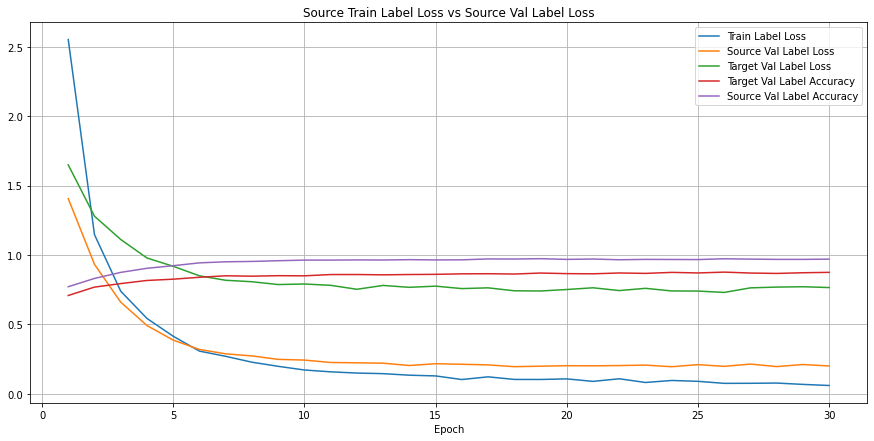

In [16]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

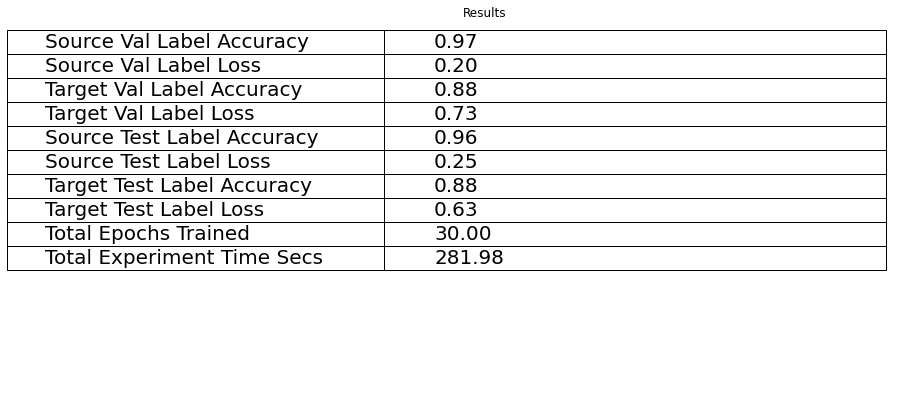

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

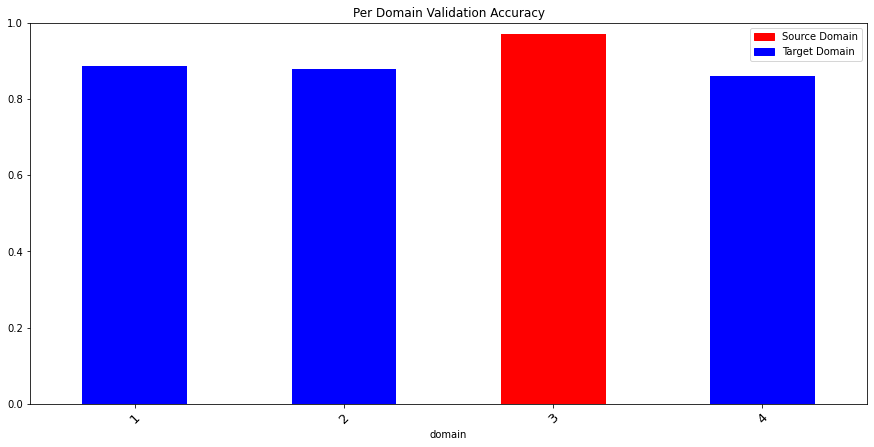

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9570512820512821 Target Test Label Accuracy: 0.8824786324786325
Source Val Label Accuracy: 0.9724358974358974 Target Val Label Accuracy: 0.8762820512820513


In [20]:
json.dumps(experiment)

'{"experiment_name": "tuned_1v2:wisig", "parameters": {"experiment_name": "tuned_1v2:wisig", "device": "cuda", "lr": 0.0001, "labels_source": ["1-10", "1-12", "1-14", "1-16", "1-18", "1-19", "1-8", "10-11", "10-17", "10-4", "10-7", "11-1", "11-10", "11-19", "11-20", "11-4", "11-7", "12-19", "12-20", "12-7", "13-14", "13-18", "13-19", "13-20", "13-3", "13-7", "14-10", "14-11", "14-12", "14-13", "14-14", "14-19", "14-20", "14-7", "14-8", "14-9", "15-1", "15-19", "15-6", "16-1", "16-16", "16-19", "16-20", "17-10", "17-11", "18-1", "18-10", "18-11", "18-12", "18-13", "18-14", "18-15", "18-16", "18-17", "18-19", "18-2", "18-20", "18-4", "18-5", "18-7", "18-8", "18-9", "19-1", "19-10", "19-11", "19-12", "19-13", "19-14", "19-15", "19-19", "19-2", "19-20", "19-3", "19-4", "19-6", "19-7", "19-8", "19-9", "2-1", "2-13", "2-15", "2-3", "2-4", "2-5", "2-6", "2-7", "2-8", "20-1", "20-12", "20-14", "20-15", "20-16", "20-18", "20-19", "20-20", "20-3", "20-4", "20-5", "20-7", "20-8", "3-1", "3-13", "